In [1]:
# TouchBistro Datathon: Customer Spend Insights
# Séamus Chai

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

Matplotlib is building the font cache; this may take a moment.


In [2]:
# 1. Data Loading
print("Loading datasets...")
# Adjust file paths as needed
venues = pd.read_csv('venues.csv')
bills = pd.read_csv('bills.csv')

# Display basic information
print(f"Venues dataset shape: {venues.shape}")
print(f"Bills dataset shape: {bills.shape}")

Loading datasets...
Venues dataset shape: (601, 5)
Bills dataset shape: (8954786, 20)


In [3]:
# 2. Data Preparation
print("\nMerging and cleaning data...")
# Merge datasets
data = bills.merge(venues, on='venue_xref_id', how='left')

# Basic data cleaning
data = data[data['bill_total_billed'] > 0]  # Remove zero or negative bills
data = data[data['payment_total_tip'] >= 0]  # Ensure tips are non-negative

# Focus on key fields for Customer Spend Insights
spend_data = data[['order_take_out_type_label', 'payment_total_tip', 
                  'bill_total_billed', 'bill_uuid', 'order_duration_seconds']]

# Handle missing values
spend_data = spend_data.dropna(subset=['order_take_out_type_label', 'bill_total_billed'])
spend_data['payment_total_tip'] = spend_data['payment_total_tip'].fillna(0)


Merging and cleaning data...


In [4]:
# 3. Feature Engineering
print("\nCalculating derived metrics...")
# Calculate tip percentage
spend_data['tip_percentage'] = (spend_data['payment_total_tip'] / spend_data['bill_total_billed']) * 100


Calculating derived metrics...


In [5]:
# 4. Exploratory Analysis
print("\nAnalyzing order types...")
# Count orders by type
order_counts = spend_data['order_take_out_type_label'].value_counts()
print("Orders by type:")
print(order_counts)

# Group by order type and calculate statistics
order_type_summary = spend_data.groupby('order_take_out_type_label').agg({
    'bill_total_billed': ['mean', 'median', 'count'],
    'payment_total_tip': ['mean', 'median', 'sum'],
    'tip_percentage': ['mean', 'median']
}).reset_index()

# Flatten the column hierarchy
order_type_summary.columns = ['_'.join(col).strip('_') for col in order_type_summary.columns.values]

# Display summary
print("\nOrder type summary statistics:")
print(order_type_summary)


Analyzing order types...
Orders by type:
order_take_out_type_label
dinein         7301566
takeout         914417
onlineorder     265366
bartab          213773
delivery         16671
Name: count, dtype: int64

Order type summary statistics:
  order_take_out_type_label  bill_total_billed_mean  bill_total_billed_median  \
0                    bartab               41.499097                     24.50   
1                  delivery               48.120948                     33.90   
2                    dinein               38.124260                     21.99   
3               onlineorder               40.304642                     34.55   
4                   takeout               33.830286                     23.52   

   bill_total_billed_count  payment_total_tip_mean  payment_total_tip_median  \
0                   213773                4.853535                       1.5   
1                    16671                1.207611                       0.0   
2                  7301566      


Creating visualizations...


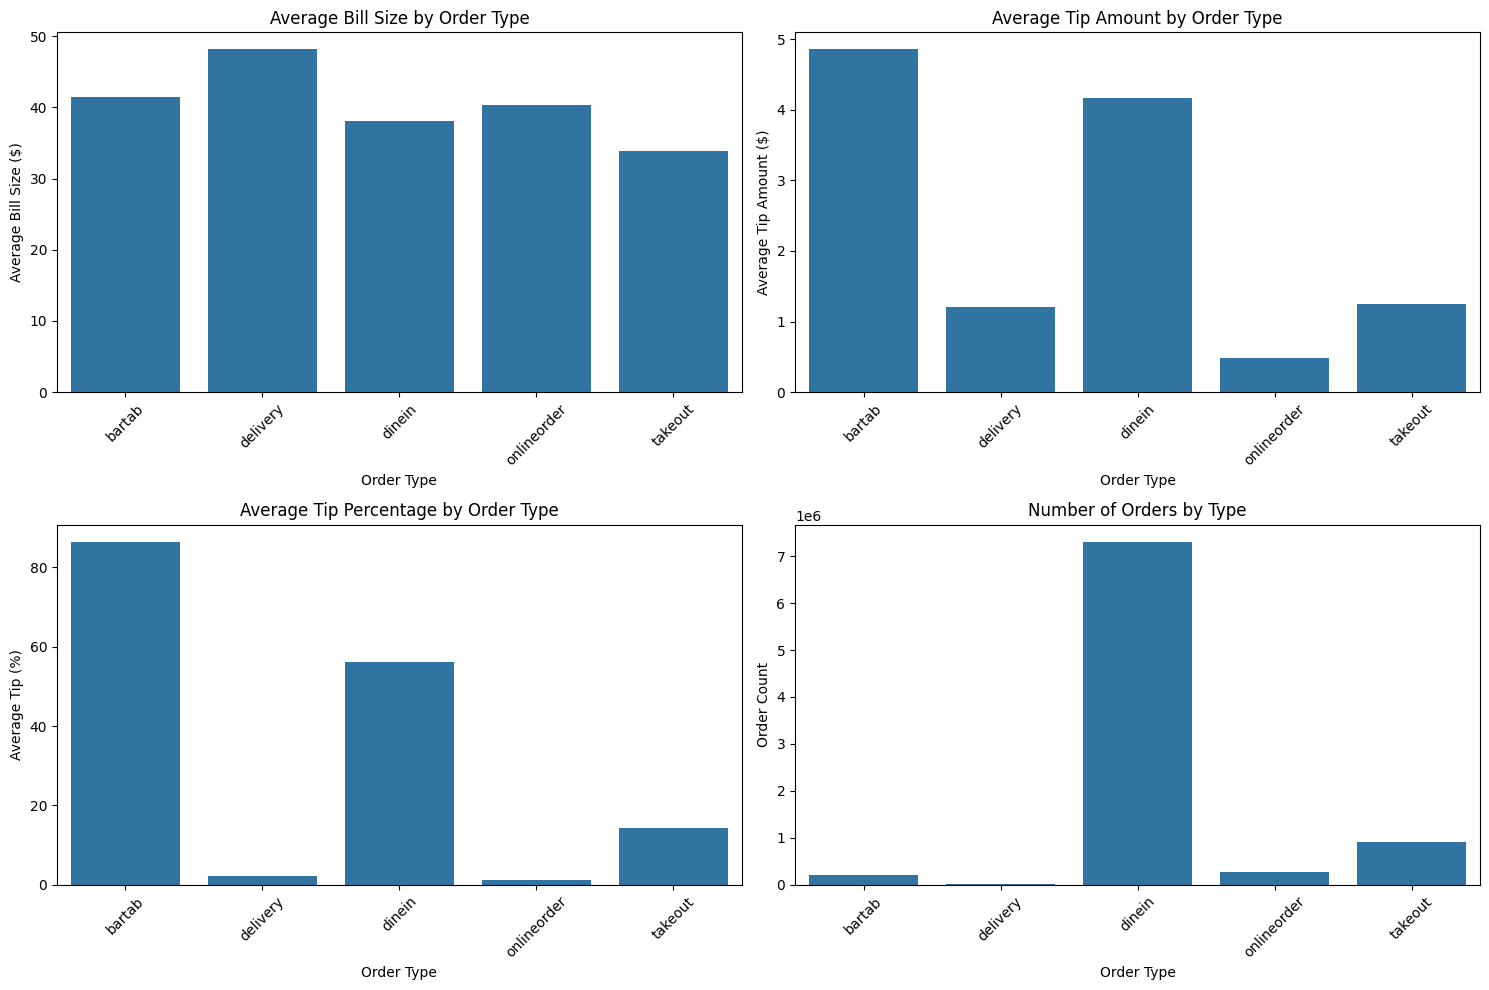

In [6]:
# 5. Visualizations
print("\nCreating visualizations...")
plt.figure(figsize=(15, 10))

# Average bill size by order type
plt.subplot(2, 2, 1)
sns.barplot(x='order_take_out_type_label', y='bill_total_billed_mean', data=order_type_summary)
plt.title('Average Bill Size by Order Type')
plt.xlabel('Order Type')
plt.ylabel('Average Bill Size ($)')
plt.xticks(rotation=45)

# Average tip amount by order type
plt.subplot(2, 2, 2)
sns.barplot(x='order_take_out_type_label', y='payment_total_tip_mean', data=order_type_summary)
plt.title('Average Tip Amount by Order Type')
plt.xlabel('Order Type')
plt.ylabel('Average Tip Amount ($)')
plt.xticks(rotation=45)

# Average tip percentage by order type
plt.subplot(2, 2, 3)
sns.barplot(x='order_take_out_type_label', y='tip_percentage_mean', data=order_type_summary)
plt.title('Average Tip Percentage by Order Type')
plt.xlabel('Order Type')
plt.ylabel('Average Tip (%)')
plt.xticks(rotation=45)

# Order count by type
plt.subplot(2, 2, 4)
sns.barplot(x='order_take_out_type_label', y='bill_total_billed_count', data=order_type_summary)
plt.title('Number of Orders by Type')
plt.xlabel('Order Type')
plt.ylabel('Order Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('order_type_analysis.png')
plt.show()

In [8]:
# 6. Simple Modeling
print("\nBuilding model to quantify relationships...")
# Prepare features
X = spend_data[['order_take_out_type_label', 'bill_total_billed']]
y = spend_data['payment_total_tip']

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['order_take_out_type_label'])
    ],
    remainder='passthrough'
)

# Create pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train model
model.fit(X, y)

# Get feature names after one-hot encoding
cat_features = model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()
feature_names = list(cat_features) + ['bill_size']

# Get coefficients
coefficients = pd.DataFrame(
    model.named_steps['regressor'].coef_,
    index=feature_names,
    columns=['Impact on Tip Amount']
)

# Print the model results
print("\nModel Results - Impact of Order Type and Bill Size on Tip Amount:")
print(coefficients)


Building model to quantify relationships...

Model Results - Impact of Order Type and Bill Size on Tip Amount:
                                       Impact on Tip Amount
order_take_out_type_label_bartab                   2.386197
order_take_out_type_label_delivery                -1.706201
order_take_out_type_label_dinein                   1.922825
order_take_out_type_label_onlineorder             -1.906069
order_take_out_type_label_takeout                 -0.696753
bill_size                                          0.067424


In [9]:
# 7. Key Findings Summary
print("\nKey Findings:")
print(f"Order type with highest average bill: {order_type_summary.loc[order_type_summary['bill_total_billed_mean'].idxmax(), 'order_take_out_type_label']}")
print(f"Order type with highest average tip %: {order_type_summary.loc[order_type_summary['tip_percentage_mean'].idxmax(), 'order_take_out_type_label']}")
print(f"Order type with lowest average tip %: {order_type_summary.loc[order_type_summary['tip_percentage_mean'].idxmin(), 'order_take_out_type_label']}")


Key Findings:
Order type with highest average bill: delivery
Order type with highest average tip %: bartab
Order type with lowest average tip %: onlineorder


In [10]:
# 8. Export results for submission
order_type_summary.to_csv('submission.csv', index=False)
print("\nResults exported to submission.csv")


Results exported to submission.csv
